In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/MyDrive/NoiceGAN/Test7'

Mounted at /content/gdrive


# Load and prepare dataset

In [2]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [47]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [48]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [49]:
amount_to_Cut = int(np.floor((np.ma.size(train_images,axis=0)/BATCH_SIZE))*BATCH_SIZE)

train_images = train_images[:amount_to_Cut,:,:]
train_labels = train_labels[:amount_to_Cut,:]


In [50]:
train_images = (train_images) / 256  # Normalize the images to [0, 1]
train_images = train_images.astype(np.float32)

test_images = (test_images) / 256
test_images = test_images.astype(np.float32)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.11111111, 0.11111111, 0.11111111, 0.        , 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111],
      dtype=float32)>

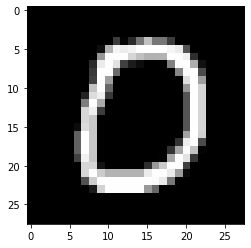

In [51]:
plt.plot()
plt.imshow(test_images[10,:, :], cmap='gray')
(tf.ones_like(train_labels[10])-train_labels[10])/9

In [52]:
# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_Output = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

# Create Models

### Generator

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(20+10,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Remover

In [10]:
def make_remover_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(20+10,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

### Discriminator

In [25]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(10))

    return model

# Define Loss and Optimizers

In [11]:
# This method returns a helper function to compute cross entropy loss
cross_entropy_categorical = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cross_entropy_binary = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [12]:
def discriminator_loss(y_pred,y_real):
    return cross_entropy_categorical(y_real,y_pred)

In [13]:
def remover_loss(y_pred,y_real,gen_out,lambda_parameter):


    indices = tf.math.argmax(y_real,axis=1)

    arr = []
    for i in range(BATCH_SIZE):
      arr.append(y_pred[i,indices[i]])

    final_cross_entropy = cross_entropy_binary(tf.zeros_like(indices),arr)

    #norm_calculated = tf.norm(gen_out,ord=2,axis=[1,2])
    #lp_loss = tf.reduce_mean(norm_calculated)

    #final_loss = final_cross_entropy+lambda_parameter*lp_loss

    return final_cross_entropy

In [14]:
def generator_loss(y_pred,y_real,gen_out,lambda_parameter):


    indices = tf.math.argmax(y_real,axis=1)

    arr = []
    for i in range(BATCH_SIZE):
      arr.append(y_pred[i,indices[i]])

    final_cross_entropy = cross_entropy_binary(tf.zeros_like(indices),arr)

    #norm_calculated = tf.norm(gen_out,ord=2,axis=[1,2])
    #lp_loss = tf.reduce_mean(norm_calculated)

    #final_loss = final_cross_entropy+lambda_parameter*lp_loss
    
    #--------------------------All Neurons---------------------------------

    # # CROSS-ENTROPY-CATEGORICAL
    # # There must be a better way to do this, look into it more later!
    # mean_tensor_single = tf.math.reduce_mean(y_pred,axis=1)
    # mean_tensor_multi = tf.stack([mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single,mean_tensor_single],axis=1)
    # final_cross_entropy = cross_entropy_categorical(mean_tensor_multi,y_pred)

    # #GENERATOR OUTPUT L2 LOSS
    # flattened_x = tf.reshape(gen_out,(BATCH_SIZE,28*28))
    # norm_calculated = tf.norm(flattened_x,ord=2,axis=1)
    # lp_loss = tf.reduce_mean(norm_calculated)

    # #SUM OF THE TWO WITH WEIGHT
    # final_loss = final_cross_entropy+0.3*lp_loss

    #--------------------------Single Neuron---------------------------------

    # indices = tf.math.argmax(y_real,axis=1)

    # arr = []
    # for i in range(BATCH_SIZE):
    #   arr.append(y_pred[i,indices[i]])

    # mean_tensor_single = tf.math.reduce_mean(y_pred,axis=1)

    # final_cross_entropy = cross_entropy_categorical(mean_tensor_single,arr)

    # #GENERATOR OUTPUT L2 LOSS
    # flattened_x = tf.reshape(gen_out,(BATCH_SIZE,28*28))
    # norm_calculated = tf.norm(flattened_x,ord=2,axis=1)
    # lp_loss = tf.reduce_mean(norm_calculated)

    # #SUM OF THE TWO WITH WEIGHT
    # final_loss = final_cross_entropy+0*lp_loss



    return final_cross_entropy






In [15]:
def disc_evaluate(x,y):

  predictions = np.argmax(discriminator(x).numpy(),axis=1)
  
  return 1-((np.count_nonzero(np.argmax(y,axis=1)-predictions))/BATCH_SIZE)

In [16]:
def gen_norm_mean(x):
  #flattened_x = np.reshape(x,(BATCH_SIZE,28*28))
  norm_calculated = tf.norm(x,ord=2,axis=[1,2])
  norm_mean = tf.math.reduce_mean(norm_calculated)
  return norm_mean.numpy()

In [56]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
remover_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# Define training loop

In [18]:
EPOCHS = 500
noise_dim = 20
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

rand_y = [0,1,2,3,4,5,6,7,8]
rand_y = tf.keras.utils.to_categorical(rand_y, 10)
#print(rand_y)
#rand_y = np.append(np.ones((num_examples_to_generate,1)),np.zeros((num_examples_to_generate, 9)),axis=1)

seed = np.append(rand_y,tf.random.normal([num_examples_to_generate, noise_dim]),axis=1)


In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_only_gen(train_X,train_Y,lambda_norm):
    train_X = tf.cast(train_X, tf.float32)
    rand_y_in = tf.experimental.numpy.append(train_Y, tf.random.normal([BATCH_SIZE, noise_dim]), axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_y_in, training=True)
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y,generated_noise)
      disc_loss = discriminator_loss(disc_output, train_Y)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    #gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    #discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_together(train_X,train_Y,lambda_norm):
    train_X = tf.cast(train_X, tf.float32)
    rand_y_in = tf.experimental.numpy.append(train_Y, tf.random.normal([BATCH_SIZE, noise_dim]), axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_y_in, training=True)
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y,generated_noise,lambda_norm)
      disc_loss = discriminator_loss(disc_output, train_Y)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step_only_disc(train_X,train_Y,lambda_norm):
    train_X = tf.cast(train_X, tf.float32)
    rand_y_in = tf.experimental.numpy.append(train_Y, tf.random.normal([BATCH_SIZE, noise_dim]), axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_noise = generator(rand_y_in, training=True)
      generated_noise = tf.squeeze(generated_noise)
      
      disc_output = discriminator(generated_noise+train_X, training=True)

      gen_loss = generator_loss(disc_output,train_Y,generated_noise)
      disc_loss = discriminator_loss(disc_output, train_Y)

    #gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [22]:
def train(dataset, epochs,train_time):
  current_lambda = 0.4
  for epoch in range(epochs):
    print("epoch: "+ str(epoch))
    gen_loss_sum = 0
    disc_loss_sum = 0

    start = time.time()
    
    for x,y in dataset:
      train_time = train_time+1

      #Evaluation Metrics:------------------------
      rand_in = tf.random.normal([BATCH_SIZE, noise_dim])
      x = tf.cast(x, tf.float32)

      generated_noise = generator(np.append(y,rand_in,axis=1), training=False)
      generated_noise = tf.squeeze(generated_noise)

      norm_evals.append(gen_norm_mean(generated_noise))

      disc_wo_noise_accuracy.append(disc_evaluate(x,y))
      disc_w_noise_accuracy.append(disc_evaluate(x+generated_noise,y))
      #--------------------------------------------

      # if disc_w_noise_accuracy[-1]>0.99:
      #   gen_loss,disc_loss = train_step_only_gen(x,y,tf.constant())
      # elif disc_w_noise_accuracy[-1]<0.01:
      #   gen_loss,disc_loss = train_step_only_disc(x,y)
      # else:
      #   gen_loss,disc_loss = train_step_together(x,y)

      if disc_w_noise_accuracy[-1]>0.7:
        current_lambda = current_lambda - 0.05 # If the accuracy of discriminator too high, reduce lambda by 0.05
      elif disc_w_noise_accuracy[-1]<0.25 and disc_w_noise_accuracy[-1]>0.1:
        current_lambda = current_lambda + 0.05 # If the accuracy of discriminator too low, increase lambda by 0.05

      #current_lambda = disc_w_noise_accuracy[-1]
        

      gen_loss,disc_loss = train_step_together(x,y,tf.constant(current_lambda))


      gen_loss_sum = gen_loss_sum + gen_loss
      disc_loss_sum = disc_loss_sum + disc_loss
      gen_loss_evals.append(gen_loss.numpy())
      disc_loss_evals.append(disc_loss.numpy())
      lambda_evals.append(current_lambda)

      if (train_time%3)==0:

        clear_output()

        print("2nd order Norm: " + str(gen_norm_mean(generated_noise)))
        print("Discriminator w/o Noise Accuracy: "+str(disc_evaluate(x,y)))
        print("Discriminator w/  Noise Accuracy: "+str(disc_evaluate(x+generated_noise,y)))
        print("Generator Loss: "+ str(gen_loss.numpy()))
        print("Discriminator Loss: "+ str(disc_loss.numpy()))

        #generate_and_save_images(generator,seed)
        plot_metrics(norm_evals,disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals,seed,generator,train_time,lambda_evals)
      

    #print("Generator Epoch Loss: "+ str(gen_loss_sum))
    #print("Discriminator Epoch Loss: "+ str(disc_loss_sum))
    #print("-----------------------------------")

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator,epoch + 1,seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  #display.clear_output(wait=True)
  #generate_and_save_images(generator,seed)


In [23]:
def plot_metrics(norm_evals,disc_w_noise_accuracy,disc_wo_noise_accuracy,gen_loss_evals,disc_loss_evals,test_input,model,training_step,lambda_evals):

  # Three subplots sharing both x/y axes
  f, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(5, sharex=True, sharey=False,figsize=(12,8))

  ax1.plot(norm_evals,label="Norm")

  ax2.plot(disc_w_noise_accuracy,label="w Noise accuracy")
  ax2.plot(disc_wo_noise_accuracy,label="wo Noise accuracy")

  ax3.plot(gen_loss_evals,label="Gen Loss")
  ax4.plot(disc_loss_evals,label="Disc Loss")

  ax5.plot(lambda_evals,label="Lambda")
  ax5.axhline(y=0.1, color='r', linestyle='-')
  ax5.axhline(y=0.25, color='b', linestyle='-')
  ax5.axhline(y=0.7, color='y', linestyle='-')


  ax1.legend()
  ax2.legend()
  ax3.legend()
  ax4.legend()
  ax5.legend()
  # Fine-tune figure; make subplots close to each other and hide x ticks for
  # all but bottom plot.
  f.subplots_adjust(hspace=0)
  plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

  plt.savefig(images_dir+'/Graph/'+str(training_step)+'.png')
  #---------------------------------------------------------------------------------------------

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7, 10))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

    
  plt.savefig(images_dir+'/Gen_output/'+str(training_step)+'.png')

  

  plt.show()

# Train

In [53]:
discriminator = make_discriminator_model()

In [54]:
discriminator.compile(discriminator_optimizer,cross_entropy_categorical,metrics=["accuracy"])
discriminator.fit(dataset,validation_data=(test_images,test_labels),epochs=8)

Epoch 1/20
468/468 [==============================] - 6s 12ms/step - loss: 0.3762 - accuracy: 0.8920 - val_loss: 0.2065 - val_accuracy: 0.9406
Epoch 2/20
468/468 [==============================] - 6s 12ms/step - loss: 0.2027 - accuracy: 0.9415 - val_loss: 0.1576 - val_accuracy: 0.9530
Epoch 3/20
468/468 [==============================] - 6s 12ms/step - loss: 0.1566 - accuracy: 0.9544 - val_loss: 0.1167 - val_accuracy: 0.9662
Epoch 4/20
468/468 [==============================] - 6s 12ms/step - loss: 0.1304 - accuracy: 0.9617 - val_loss: 0.0961 - val_accuracy: 0.9720
Epoch 5/20
468/468 [==============================] - 6s 12ms/step - loss: 0.1140 - accuracy: 0.9669 - val_loss: 0.0863 - val_accuracy: 0.9752
Epoch 6/20
468/468 [==============================] - 6s 12ms/step - loss: 0.1032 - accuracy: 0.9704 - val_loss: 0.0756 - val_accuracy: 0.9770
Epoch 7/20
468/468 [==============================] - 6s 12ms/step - loss: 0.0950 - accuracy: 0.9722 - val_loss: 0.0724 - val_accuracy: 0.9778

KeyboardInterrupt: ignored

In [55]:
generator = make_generator_model()
remover = make_remover_model()

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 remover_optimizer=remover_optimizer,
                                 generator=generator,
                                 remover=remover,
                                 discriminator=discriminator)

In [58]:
train_time=0

In [59]:
#Initialize arrays to save metrics (to plot)
norm_evals = []
disc_w_noise_accuracy = []
disc_wo_noise_accuracy = []
gen_loss_evals = []
disc_loss_evals = []
lambda_evals = []

In [ ]:
train(dataset, EPOCHS,train_time)

2nd order Norm: 17.256874
Discriminator w/o Noise Accuracy: 0.7578125
Discriminator w/  Noise Accuracy: 0.765625
Generator Loss: 1.8728936
Discriminator Loss: 0.961642


KeyboardInterrupt: ignored